
```
Suyash Pasari & Shreyas Prabhudev
```

## Retrieval-Augmented Generation System Using OpenAI and Langchain for Youtube Videos and Comments

This project demonstrates how to build a retrieval-augmented generation system leveraging the latest language models and retrieval techniques. We aim to enhance the capabilities of language models by integrating them with a transcript from a Youtube video and comments that pertain to that video. Users can then query the Youtube video or comment section to get more insight.

## Project Overview

In this notebook, we'll develop a system that combines the generative capabilities of OpenAI's language models with the retrieval efficiency of Pinecone. Our goal is to create an application that can answer complex queries by retrieving relevant information from a provided video and generating accurate responses.

### Key Objectives:
To develop a Question-Answering (QA) system that leverages Retrieval-Augmented Generation (RAG) for effectively answering user queries based on YouTube video transcripts and comments.
1. **Integration of OpenAI's Language Models**: Utilize models like GPT-3.5 for generating responses based on the context provided by the retrieval system.
2. **Implementation of Pinecone for Retrieval**: Implement Pinecone to retrieve document embeddings as context for the language model, enhancing the relevance and accuracy of responses.
3. **Creation of a Responsive Interface**: Develop a user interface that allows users to input queries and receive responses dynamically.

### Problem Statement



1.   **Content Overload**: YouTube has a vast amount of content, making it challenging for users to find specific information within videos.
2.   **Inefficient Search**: Current search functionalities on YouTube often fail to provide direct answers to user queries, requiring users to sift through entire videos.
3.   **Engagement Gap**: Users seek more interactive and precise ways to engage with video content, especially for educational and informational videos.

Methodology

1.   Data Collection:

Transcripts: Extracting transcripts from YouTube videos using YouTube's API.

Comments: Extracting user comments from YouTube videos.

2. Data Preprocessing:

Cleaning: Removing noise from transcripts and comments (e.g., timestamps, irrelevant text).

Normalization: Converting text to a uniform format (e.g., lowercasing, removing punctuation).

        

3. Model Selection:

Retrieval Component: Using a pre-trained language model (e.g., GPT3.5) to retrieve relevant passages from transcripts and comments.

Generation Component: Using a transformer-based language model (e.g., GPT) to generate answers based on the retrieved information.


4. Evaluation
Giskard is an open-source Python library that automatically detects performance, bias & security issues in AI applications. The library covers LLM-based applications such as RAG agents, all the way to traditional ML models for tabular data.

Automatically generate evaluation datasets & evaluate RAG application answers

### Tools and Technologies Used:

- **OpenAI API**: For accessing state-of-the-art language models.
- **Pinecone**: For efficient management and retrieval of vector embeddings at a large scale
- **Python Libraries**: Pytube for downloading videos, Whisper for transcription, and various data handling libraries.


We can begin by installing and loading the packages we are going to use.

In [ ]:
!pip install pytube3 whisper-openai nltk
!pip install --upgrade pytube
!pip install langchain-openai langchain-core
!pip install langchain
!pip install -U langchain-pinecone
!pip install -U --quiet langchain_experimental langchain_community docarray pydantic==1.10.8 ruff bs4 ipytest giskard[llm]

from nltk.sentiment import SentimentIntensityAnalyzer
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

import os
from google.colab import userdata

import googleapiclient.discovery
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

import tempfile
import whisper
from pytube import YouTube
from langchain_pinecone import PineconeVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_openai.embeddings import OpenAIEmbeddings

Here we are adding in our OpenAI API key and the link to our Youtube video. Generally, processing an hour long video using Whisper can range from 45 minutes to over 60 minutes depending on the compute resources used.

In [ ]:
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# YOUTUBE_VIDEOS = ["https://youtu.be/mAUpxN-EIgU?si=HXrZpPzYl6rEdF5q" ,"https://www.youtube.com/watch?v=uEl2KUZ3JWA"  ]
YOUTUBE_VIDEOS = ["https://www.youtube.com/watch?v=23xw1taanW0", "https://www.youtube.com/watch?v=jV1vkHv4zq8"]
YOUTUBE_VIDEO = YOUTUBE_VIDEOS[0]
YOUTUBE_VIDEO2 = YOUTUBE_VIDEOS[1]

## Data Retrieval and Preparation

#### Youtube Comments Retrieval

**Objective:**
Retrieve YouTube comments using the Google YouTube Data API to gather a dataset that will be used as additional context in the retrieval-augmented generation system. This data will also serve as input for sentiment analysis.

**Description:**
In this section, we will use the Google API Client Library to access YouTube's Data API, allowing us to fetch comments from specific videos. The comments will be stored in a pandas DataFrame, which facilitates easier manipulation and analysis in subsequent steps.


In [ ]:
# API setup
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = userdata.get('YOUTUBE_API_KEY')

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

def get_comments(video_id):
    comments = []
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100
    )

    # Fetching comments
    while True:
        response = request.execute()
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comments.append({
                'author': comment['authorDisplayName'],
                'published_at': comment['publishedAt'],
                'like_count': comment['likeCount'],
                'text': comment['textOriginal'],
                'public': item['snippet']['isPublic']
            })
        if 'nextPageToken' in response:
            request = youtube.commentThreads().list(
                part="snippet",
                videoId=video_id,
                pageToken=response['nextPageToken'],
                maxResults=100
            )
        else:
            break
    return pd.DataFrame(comments)



In [ ]:
# Use the video id from a Youtube URL as a unique identifier
video_ids = ["23xw1taanW0", "jV1vkHv4zq8"]
video_id = video_ids[0]
comments_df = get_comments(video_id)
comments_df.head()
# Use the video id from a Youtube URL as a unique identifier
video_id = video_ids[1]
comments_df2 = get_comments(video_id)
comments_df2.head()

,author,published_at,like_count,text,public
0,@MdBabumolla-sz4th,2024-05-11T15:21:22Z,0,you job mi,True
1,@kastetetekas8247,2024-05-11T14:37:48Z,0,Moi sur mon Xiaomi ça le fait surchauffer et i...,True
2,@thefreakbinge,2024-05-11T10:28:10Z,0,"I use Gemini, and I must say. What an engine!\...",True
3,@Canaldoqueijomontese1997,2024-05-10T00:46:50Z,0,Boa noite! YouTube - Canal do queijo Montese.,True
4,@VRTRIPTIPS,2024-05-07T17:40:33Z,0,https://youtu.be/mcj9FRvLlXI?si=3u1xOAx29ZKZZ2uR,True


In [ ]:
comments_df.head()

,author,published_at,like_count,text,public
0,@Jossie_188,2024-05-14T02:01:13Z,0,"too much emotion I think, they should improve ...",True
1,@mygamecomputer1691,2024-05-14T01:14:13Z,0,Why am I paying $22 a month for ChatGPT 4 though?,True
2,@DrN007,2024-05-13T22:45:33Z,0,This is what Alexa and Siri were supposed to b...,True
3,@oatsmobile6508,2024-05-13T22:42:39Z,0,"Thanks, I hate it.",True
4,@pn4960,2024-05-13T22:02:33Z,2,"i hope you can limit the ""emotion"" tone becaus...",True


In [ ]:
comments_df2.head()

,author,published_at,like_count,text,public
0,@MdBabumolla-sz4th,2024-05-11T15:21:22Z,0,you job mi,True
1,@kastetetekas8247,2024-05-11T14:37:48Z,0,Moi sur mon Xiaomi ça le fait surchauffer et i...,True
2,@thefreakbinge,2024-05-11T10:28:10Z,0,"I use Gemini, and I must say. What an engine!\...",True
3,@Canaldoqueijomontese1997,2024-05-10T00:46:50Z,0,Boa noite! YouTube - Canal do queijo Montese.,True
4,@VRTRIPTIPS,2024-05-07T17:40:33Z,0,https://youtu.be/mcj9FRvLlXI?si=3u1xOAx29ZKZZ2uR,True


## Data Preparation

**Objective:**
Prepare the retrieved YouTube comments for both sentiment analysis and inclusion in the retrieval system by performing necessary preprocessing steps.

**Description:**
Before integrating the YouTube comments into our retrieval system and conducting sentiment analysis, it's crucial to clean and normalize the data. This step ensures the removal of irrelevant characters, standardizes the date format, and prepares the text for analysis.

In [ ]:
# Data cleaning function
def clean_text(text):
    cleaned_text = text.replace("&amp;", "&").replace("&#39;", "'")
    return cleaned_text

# Applying cleaning function to the comment texts
comments_df['cleaned_text'] = comments_df['text'].apply(clean_text)
comments_df.head()
comments_df2['cleaned_text'] = comments_df2['text'].apply(clean_text)
comments_df2.head()

,author,published_at,like_count,text,public,cleaned_text
0,@MdBabumolla-sz4th,2024-05-11T15:21:22Z,0,you job mi,True,you job mi
1,@kastetetekas8247,2024-05-11T14:37:48Z,0,Moi sur mon Xiaomi ça le fait surchauffer et i...,True,Moi sur mon Xiaomi ça le fait surchauffer et i...
2,@thefreakbinge,2024-05-11T10:28:10Z,0,"I use Gemini, and I must say. What an engine!\...",True,"I use Gemini, and I must say. What an engine!\..."
3,@Canaldoqueijomontese1997,2024-05-10T00:46:50Z,0,Boa noite! YouTube - Canal do queijo Montese.,True,Boa noite! YouTube - Canal do queijo Montese.
4,@VRTRIPTIPS,2024-05-07T17:40:33Z,0,https://youtu.be/mcj9FRvLlXI?si=3u1xOAx29ZKZZ2uR,True,https://youtu.be/mcj9FRvLlXI?si=3u1xOAx29ZKZZ2uR


In [ ]:
# Function to calculate sentiment
def get_sentiment(text):
    testimonial = TextBlob(text)
    return testimonial.sentiment.polarity

# Convert polarity scores to sentiment categories
def assign_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity == 0:
        return 'neutral'
    else:
        return 'negative'

comments_df['polarity'] = comments_df['cleaned_text'].apply(get_sentiment)
comments_df['sentiment'] = comments_df['polarity'].apply(assign_sentiment)

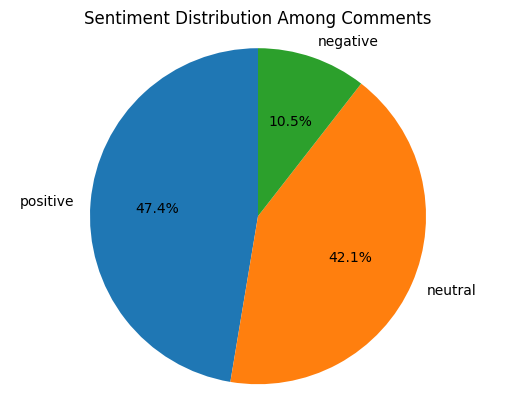

In [ ]:
# Pie chart for sentiment distribution
sentiment_counts = comments_df['sentiment'].value_counts()
fig, ax = plt.subplots()
ax.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title('Sentiment Distribution Among Comments')
plt.show()

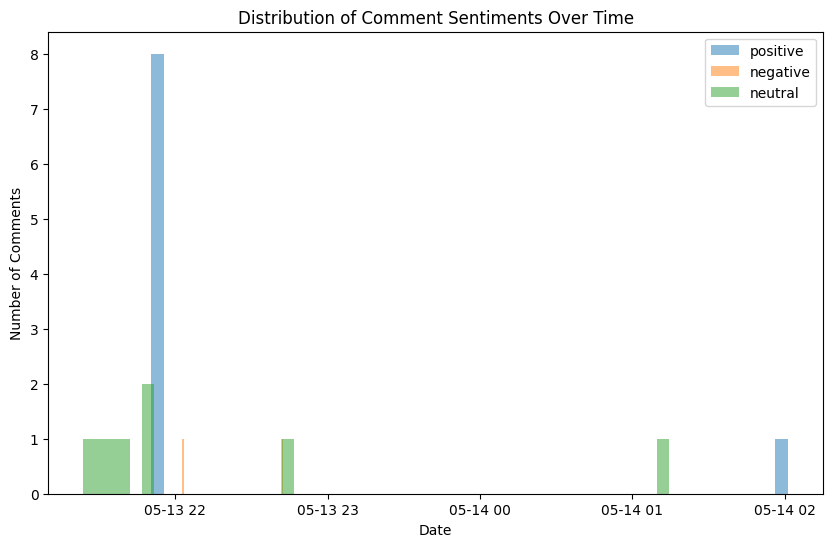

In [ ]:
# Convert 'published_at' to datetime and plot histogram for comment sentiment over time
comments_df['published_at'] = pd.to_datetime(comments_df['published_at'])

plt.figure(figsize=(10, 6))
for sentiment in ['positive', 'negative', 'neutral']:
    subset = comments_df[comments_df['sentiment'] == sentiment]
    plt.hist(subset['published_at'], bins=50, alpha=0.5, label=sentiment)

plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.title('Distribution of Comment Sentiments Over Time')
plt.legend()
plt.show()


In [ ]:
comments_df

,author,published_at,like_count,text,public,cleaned_text,polarity,sentiment
0,@DrN007,2024-05-13 22:45:33+00:00,0,This is what Alexa and Siri were supposed to b...,True,This is what Alexa and Siri were supposed to b...,0.000000,neutral
1,@oatsmobile6508,2024-05-13 22:42:39+00:00,0,"Thanks, I hate it.",True,"Thanks, I hate it.",-0.300000,negative
2,@pn4960,2024-05-13 22:02:33+00:00,1,"i hope you can limit the ""emotion"" tone becaus...",True,"i hope you can limit the ""emotion"" tone becaus...",-0.800000,negative
3,@ChadrickWollam,2024-05-13 21:51:17+00:00,0,Dont just invest; invest wisely with Revux – t...,True,Dont just invest; invest wisely with Revux – t...,0.183333,positive
4,@PriceVillandry,2024-05-13 21:51:06+00:00,0,Revux isnt following trends; its setting them ...,True,Revux isnt following trends; its setting them ...,0.000000,neutral
5,@LottieMahl,2024-05-13 21:51:01+00:00,0,"In the ever-evolving crypto space, Revux is no...",True,"In the ever-evolving crypto space, Revux is no...",0.000000,neutral
6,@DereckSwierenga,2024-05-13 21:50:51+00:00,0,Unleash the full potential of your crypto port...,True,Unleash the full potential of your crypto port...,0.131061,positive
7,@AstridGerlach,2024-05-13 21:50:50+00:00,0,For investors seeking the extraordinary in cry...,True,For investors seeking the extraordinary in cry...,0.122222,positive
8,@GeovannySaterfiel,2024-05-13 21:50:47+00:00,0,Revux isnt a fleeting sensation; its a lasting...,True,Revux isnt a fleeting sensation; its a lasting...,0.075000,positive
9,@MariannaBlossom,2024-05-13 21:50:45+00:00,0,"As the crypto world evolves, Revux emerges as ...",True,"As the crypto world evolves, Revux emerges as ...",0.060000,positive


In [ ]:
def retrieve_comments(query, sentiment_preference='neutral', top_n=5):
    # Filter for sentiment preference and create a copy to avoid SettingWithCopyWarning
    filtered_comments = comments_df[comments_df['sentiment'] == sentiment_preference].copy()

    # Simple match of query words in comments (not case sensitive)
    filtered_comments['relevance_score'] = filtered_comments['text'].apply(
        lambda x: sum(word.lower() in x.lower() for word in query.split())
    )

    # Sorting by relevance score and returning top N
    top_comments = filtered_comments.sort_values(by='relevance_score', ascending=False).head(top_n)
    return top_comments[['text', 'relevance_score']]

query = "What are the best features of this product?"
retrieved_comments = retrieve_comments(query, sentiment_preference='positive')
print(retrieved_comments)

                                                 text  relevance_score
14  Investors seeking the next frontier in crypto ...                3
8   Unleash the full potential of your crypto port...                2
9   For investors seeking the extraordinary in cry...                2
10  Revux isnt a fleeting sensation; its a lasting...                2
11  As the crypto world evolves, Revux emerges as ...                2


In [ ]:
# Extract the comments column
comments = comments_df['cleaned_text']
comments2 = comments_df2['cleaned_text']

# # Open the text file in append mode and write the comments
# with open('transcription.txt', 'a') as f:
#     for comment in comments:
#         f.write(comment + '\n')

# Get Transcript from YT Video and build a vector DB

Transcribe the youtube video using Whisper


In [ ]:
# Initialize Whisper Model
if not os.path.exists("transcription.txt"):

    youtube = YouTube(YOUTUBE_VIDEOS[0])
    audio = youtube.streams.filter(only_audio=True).first()

    youtube2 = YouTube(YOUTUBE_VIDEOS[1])
    audio2 = youtube2.streams.filter(only_audio=True).first()

    whisper_model = whisper.load_model("base")

    with tempfile.TemporaryDirectory() as tmpdir:
        file = audio.download(output_path=tmpdir)
        file2 = audio2.download(output_path=tmpdir)
        t1 = whisper_model.transcribe(file, fp16=False)["text"].strip()
        t2 = whisper_model.transcribe(file2, fp16=False)["text"].strip()
        # Extract the comments column
        extract_clean_comments = comments_df['cleaned_text']
        extract_clean_comments2 = comments_df2['cleaned_text']
        with open("transcription.txt", "w") as file:
          file.write(t1 + '\n')
          for comment in extract_clean_comments:
              file.write(comment + '\n')

          file.write(t2 + '\n')
          for comment in extract_clean_comments2:
              file.write(comment + '\n')

with open("transcription.txt") as file:
    transcription = file.read()




In [ ]:
transcription

'So open AI just dropped a bombshell at their spring update event on Monday. They\'ve unleashed a brand new model called GPT40 and trust me, this thing is going to change the game like never before. So what\'s the big deal about it? For starters, it\'s packing some serious GPT4 level power and here\'s the kicker, it\'s available to everyone even if you\'re not paying for a subscription. Open AI\'s headhuncho, Sam Altman had been dropping hints about some cool new features coming to chat GPT and GPT4 and while he crushed our dreams of a GPT5 or an open AI search engine, the GPT40 announcement has the AI world going absolutely nuts. During the event, open AI\'s top tech guru Mirra Murati took the stage to give us the lowdown on GPT40. She called it a huge step forward in making AI super easy to use and accessible to everyone. No more exclusive clubs or VIP access needed, GPT40 is here for the masses. Now get this, GPT40 can work its magic across voice, text and even vision. Its older sib

In [ ]:
# Embed and Upload Transcription to Pinecone
def embed_and_upload_to_pinecone(transcription, openai_api_key, pinecone_api_key, index_name):
    embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

    # Load the transcription from a file
    loader = TextLoader("transcription.txt")
    transcription = loader.load()

    # Split the document into smaller chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
    document_texts = text_splitter.split_documents(transcription)

    os.environ["PINECONE_API_KEY"] = pinecone_api_key
    pinecone = PineconeVectorStore.from_documents(document_texts, embeddings, index_name=index_name)
    return pinecone

pinecone = embed_and_upload_to_pinecone(transcription, userdata.get('OPENAI_API_KEY'), userdata.get('PINECONE_API_KEY'), "cs252pinecone")

# Set up the RAG system
model = ChatOpenAI(openai_api_key=userdata.get('OPENAI_API_KEY'), model="gpt-3.5-turbo")
template = """
Answer the question based on the context below. If you can't
answer the question, reply "I don't know".

Context: {context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
parser = StrOutputParser()

baseline_chain = (
    {"context": pinecone.as_retriever(), "question": RunnablePassthrough()}
    | prompt
    | model
    | parser
)

In [ ]:
loader = TextLoader("transcription.txt")
transcription = loader.load()

# Split the document into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
documents= text_splitter.split_documents(transcription)
documents

[Document(page_content="So open AI just dropped a bombshell at their spring update event on Monday. They've unleashed a brand new model called GPT40 and trust me, this thing is going to change the game like never before. So what's the big deal about it? For starters, it's packing some serious GPT4 level power and here's the kicker, it's available to everyone even if you're not paying for a subscription. Open AI's headhuncho, Sam Altman had been dropping hints about some cool new features coming to chat GPT and GPT4 and while he crushed our dreams of a GPT5 or an open AI search engine, the GPT40 announcement has the AI world going absolutely nuts. During the event, open AI's top tech guru Mirra Murati took the stage to give us the lowdown on GPT40. She called it a huge step forward in making AI super easy to use and accessible to everyone. No more exclusive clubs or VIP access needed, GPT40 is here for the masses. Now get this, GPT40 can work its magic across voice, text and even vision

## Create a Knowledge Base

Let's start by loading the content in a pandas DataFrame.

In [ ]:
df = pd.DataFrame([d.page_content for d in documents], columns=["text"])
df.head(10)

,text
0,So open AI just dropped a bombshell at their s...
1,older sibling GPT4 could already analyze image...
2,"What would you say? Mike, she wonders if Wales..."
3,"voice at lightning speed, dishing out tips on ..."
4,They're making this incredible tech accessible...
5,This is what Alexa and Siri were supposed to b...
6,For investors seeking the extraordinary in cry...
7,Investors seeking the next frontier in crypto ...
8,"You know, one of the reasons we got interested..."
9,"Traditionally, multimodal models are created b..."


In [ ]:
%pip install -U --quiet giskard[llm]

In [ ]:
!pip install -U --quiet langchain langchain-openai langchain_experimental langchain_community docarray pydantic==1.10.8 ruff bs4 ipytest giskard[llm]

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
MODEL = "gpt-3.5-turbo"

## Load the Content in a Vector Store

In [ ]:
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import DocArrayInMemorySearch

vectorstore = DocArrayInMemorySearch.from_documents(
    documents, embedding=OpenAIEmbeddings()
)

We can now create a Knowledge Base using the DataFrame we created before.

In [ ]:
from giskard.rag import KnowledgeBase

knowledge_base = KnowledgeBase(df)

## Generate the Test Set

In [ ]:
from giskard.rag import generate_testset

testset = generate_testset(
    knowledge_base,
    num_questions=20,
    agent_description="A chatbot answering questions about the AI LLM models",
)

INFO:giskard.rag:Finding topics in the knowledge base.
INFO:giskard.rag:Found 5 topics in the knowledge base.


Generating questions:   0%|          | 0/20 [00:00<?, ?it/s]

Let's display a few samples from the test set.

In [ ]:
test_set_df = testset.to_pandas()

for index, row in enumerate(test_set_df.head(20).iterrows()):
    print(f"Question {index + 1}: {row[1]['question']}")
    print(f"Reference answer: {row[1]['reference_answer']}")
    print("Reference context:")
    print(row[1]['reference_context'])
    print("******************", end="\n\n")


Question 1: What is the sentiment regarding the release of AI Gemini technology?
Reference answer: The sentiment is mixed. Some people are excited and looking forward to trying it out, while others are skeptical and critical, suggesting that this technology might have been released as a competitive response to OpenAI's ChatGPT. There are also concerns about the use of personal data in training these AI models.
Reference context:
Document 130: Then why the f*ck they haven't released, as if the already got these type of AI existing technology with them, before releasing OpenAI's ChatGPT. Once ChatGPT got released and taken over internet, they got triggered loosing google viewers & Ads, they putting forward AI Gemini technology out for normal people like us and to compete against ChatGPT. No wonder there may be even more efficient technologies existed and are being not shown to the world, who knows....!
Can we say that ? This is the start of artificial general intelligence.
Good try Googl

In [ ]:
testset.save("test-set.jsonl")

## Prepare the Prompt Template

In [ ]:
from langchain.prompts import PromptTemplate

template = """
Answer the question based on the context below. If you can't
answer the question, reply "I don't know".

Context: {context}

Question: {question}
"""

prompt = PromptTemplate.from_template(template)
print(prompt.format(context="Here is some context", question="Here is a question"))


Answer the question based on the context below. If you can't
answer the question, reply "I don't know".

Context: Here is some context

Question: Here is a question



## Create the RAG Chain

Create a retriever from the Vector Store that will allow us to get the top similar documents to a given question.

In [ ]:
retriever = vectorstore.as_retriever()
retriever.get_relevant_documents("What is an LLM? How does it work ?")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[Document(page_content='"it is as good as the best expert humans" The thing with experts is that they are most of the time wrong. They have false models, narratives without any evidence, and they repeat each other, creating an echo chamber. There are so many misconceptions in "science" and social fields like economy that get repeated over and over again. Use those and ask an LLM, it will never break out of the mainstream answer. Those models will never find new ways. Impressive technology, but it can´t replace original thinkers. Imagine we wake up and there is a model that gives you a scientifically correct answer. It would be anything but politically correct. It would be anything but in concert with the view of big pharma and all the other big industries and institutions. They heavily depend on narratives that are wrong but intuitive aka fallacies. Historically heads have to roll until a new discovery goes mainstream. Think about Galileo or Martin Luther. Their models were not correct

We can now create our chain.

In [ ]:
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

model = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model=MODEL)

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
    }
    | prompt
    | model
    | StrOutputParser()
)

Let's make sure the chain works by testing it with a simple question.

In [ ]:
chain.invoke({"question": "What is an LLM? How does it work ?"})

"I don't know."

## Evaluating the Model on the Test Set

We need to create a function that invokes the chain with a specific question and returns the answer.

In [ ]:
def answer_fn(question, history=None):
    return chain.invoke({"question": question})

We can now use the `evaluate()` function to evaluate the model on the test set. This function will compare the answers from the chain with the reference answers in the test set.

In [ ]:
from giskard.rag import evaluate

report = evaluate(answer_fn, testset=testset, knowledge_base=knowledge_base)

Asking questions to the agent:   0%|          | 0/20 [00:00<?, ?it/s]

correctness evaluation:   0%|          | 0/20 [00:00<?, ?it/s]

Let now display the report.

Here are the five components of our RAG application:

* **Generator**: This is the LLM used in the chain to generate the answers.
* **Retriever**: This is the retriever that fetches relevant documents from the knowledge base according to a query.
* **Rewriter**: This is a component that rewrites the user query to make it more relevant to the knowledge base or to account for chat history.
* **Router**: This is a component that filters the query of the user based on his intentions.
* **Knowledge Base**: This is the set of documents given to the RAG to generate the answers.

In [ ]:
display(report)

In [ ]:
report.to_html("report.html")

We can display the correctness results organized by question type.

In [ ]:
report.correctness_by_question_type()

,correctness
question_type,
complex,0.250000
conversational,0.000000
distracting element,1.000000
double,0.333333
simple,0.750000
situational,0.000000


We can also display the specific failures.

In [ ]:
report.get_failures()

,question,reference_answer,reference_context,conversation_history,metadata,agent_answer,correctness,correctness_reason
id,,,,,,,,
82993ad7-9c9c-406a-836e-8bb9e84e0230,What are some of the expectations from AI?,Some people expect AI to prove that it can cur...,Document 45: Hope more effective and incompara...,[],"{'question_type': 'simple', 'seed_document_id'...",Some of the expectations from AI include incor...,False,The agent's answer does not match the ground t...
ca1bb766-be38-4443-a652-92d9b43fcbff,"From the provided text, could you identify the...",The individuals being thanked in the text are ...,Document 165: THE BLESSINGS FROM MY BEAUTIFUL ...,[],"{'question_type': 'complex', 'seed_document_id...","From the provided text, the names of the indiv...",False,The agent identified more individuals than the...
33779aa6-0ac4-40c0-a9dd-fd8c8ba13f78,According to the information provided in the c...,The next step is to launch Gemini 2.0 in April...,Document 137: Happy to see competition in this...,[],"{'question_type': 'complex', 'seed_document_id...",The planned future advancement for Google's Ge...,False,The agent's answer does not match the ground t...
6223b41d-eb1b-4b2f-81bd-43741eb4f4a5,"Based on the context, how does the user percei...",The user perceives the AI technology as being ...,Document 51: fake\nEverything for stupid creat...,[],"{'question_type': 'complex', 'seed_document_id...",The user seems to have mixed feelings about th...,False,The agent's answer does not match the ground t...
76d0e793-876f-4136-95d1-3a86b64e7371,"As an anthropologist, I'm intrigued by the nam...",The context does not provide clear information...,Document 152: No one cares just make AGI alrea...,[],"{'question_type': 'situational', 'seed_documen...",Gemini refers to a groundbreaking AI model int...,False,The agent's answer does not match the ground t...
bbb87a08-b575-4446-8c5c-a137de2fd5b1,"As an enthusiastic mid-level python engineer, ...",The mid-level python engineer learned somethin...,Document 157: I think artificial super intelli...,[],"{'question_type': 'situational', 'seed_documen...",I don't know.,False,The agent failed to provide any information ab...
9944aa0d-bd69-45c3-b0b5-cccf944c3f48,As an AI enthusiast who's been hearing a lot a...,Users are excited about Gemini AI and expect i...,Document 128: Made with HARPA AI\nwow 443\nThi...,[],"{'question_type': 'situational', 'seed_documen...",Users generally expect the Gemini AI to have c...,False,The agent's answer does not fully match the gr...
b6d3dee6-d32d-4422-87c0-73337148a2b9,Is Gemini AI free to use on mobile and what ar...,The context does not provide information on wh...,Document 28: It’s safe to assume leftist have ...,[],"{'question_type': 'double', 'original_question...",I don't know.,False,The agent did not provide any information abou...
be1c14cd-3a84-4d23-bc9f-5a59c60fa1be,What is the user's concern about Google's AI m...,The user believes that Google's attempt to rus...,Document 70: “No one remembers who came in sec...,[],"{'question_type': 'double', 'original_question...","The user's concern about Google's AI model, Ge...",False,The agent's answer does not correctly reflect ...


## Creating a Test Suite

We can create a test suite and use it to compare different models.

Load the test set from disk.

In [ ]:
from giskard.rag import QATestset

testset = QATestset.load("test-set.jsonl")

Create a Test Suite from the test set.

In [ ]:
test_suite = testset.to_test_suite(" Test Suite")

We need a function that takes a DataFrame of questions, invokes the chain with each question, and returns the answers.

In [ ]:
import giskard


def batch_prediction_fn(df: pd.DataFrame):
    return chain.batch([{"question": q} for q in df["question"].values])

We can now create a Giskard Model object to run our test suite.

In [ ]:
giskard_model = giskard.Model(
    model=batch_prediction_fn, # Answers questions in batches instead of one by one
    model_type="text_generation",
    name="AI models Question and Answer Model", # Change to a descriptive name
    description="This model answers questions about AI models ChatGPT and Bard.", # Change to a descriptive use of the model
    feature_names=["question"],
)

INFO:giskard.models.automodel:Your 'prediction_function' is successfully wrapped by Giskard's 'PredictionFunctionModel' wrapper class.


Let's now run the test suite using the model we created before.

In [ ]:
test_suite_results = test_suite.run(model=giskard_model)

We can display the results.

In [ ]:
baseline_chain.invoke("How did Gemini source their data and content? Please give me factual evidence from the video to support your answer.")

"I don't know."

In [ ]:
baseline_chain.invoke("What is the new ChatGPT model being released called? Please give me factual evidence from the video to support your answer.")

'The new ChatGPT model being released is called GPT40. This is supported by the statement in the document that mentions, "They\'ve unleashed a brand new model called GPT40."'

In [ ]:
baseline_chain.invoke("How do people feel about OpenAI as a company?")

'Based on the context provided, some people feel positively about OpenAI as a company because they mention being interested in AI due to OpenAI creating ChatGPT.'

In [ ]:
baseline_chain.invoke("Can you give me specific Youtube comments showing how people feel about OpenAI?")

"I don't know."

## Conclusion and Future Work

This notebook demonstrates the enhanced response quality and contextual relevance achieved by incorporating YouTube comments into our retrieval-augmented generation system. By using real-world, dynamic inputs, the system provides more nuanced and sentiment-aware responses to user inquiries. This integration allows users to gain a better understanding of both the video's content and public sentiment.

Future Work:

**Refine Sentiment Analysis:** Improve accuracy using advanced NLP techniques and domain-specific models.

**Explore Advanced NLP Models:** Integrate newer, specialized language models for richer contextual understanding.

**Expand Context Sources:** Include forum posts, reviews, and social media feeds for a broader context pool.

**Interactive Feedback:** Implement user feedback loops to continually enhance model performance.

These improvements aim to further enhance the system's utility in real-world applications and advance conversational AI capabilities.







